# ML Task - Predicting LOS using window and PySpark

Start with the necessary imports...

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col, avg, hour, dayofweek, dayofmonth, month, year
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit


import matplotlib.pyplot as plt
import pandas as pd


import os

Define necessary PySpark env variables.

In [2]:
#os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-21.0.3.0.9-1.fc40.x86_64/'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_MASTER_HOST'] = 'localhost'

Building the spark session...

In [2]:
spark = SparkSession.builder \
    .appName("Setup") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()
sc = spark.sparkContext

Read the previously processed data.

In [3]:
file_path = "dataset/DS.parquet"

ds = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

ds.printSchema()
ds.show(5)

root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- LOS: double (nullable = true)
 |-- SEQ_NUM: integer (nullable = true)
 |-- TOTAL_EVENTS: long (nullable = true)
 |-- AGE_AT_ADMISSION: integer (nullable = true)
 |-- ADMITTIME: timestamp (nullable = true)
 |-- GENDER: double (nullable = true)
 |-- ADMISSION_TYPE: double (nullable = true)
 |-- MULTIPLE_ADMISSIONS: integer (nullable = true)
 |-- MULTIPLE_ICU_STAYS: integer (nullable = true)

+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|SUBJECT_ID|HADM_ID|   LOS|SEQ_NUM|TOTAL_EVENTS|AGE_AT_ADMISSION|          ADMITTIME|GENDER|ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|       295| 192988|0.9057|      2|        1246|              61|2176-03-

In [4]:
ds.describe().show()

+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+
|summary|       SUBJECT_ID|           HADM_ID|              LOS|          SEQ_NUM|     TOTAL_EVENTS|  AGE_AT_ADMISSION|             GENDER|     ADMISSION_TYPE|MULTIPLE_ADMISSIONS| MULTIPLE_ICU_STAYS|
+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+
|  count|            19891|             19891|            19891|            19891|            19891|             19891|              19891|              19891|              19891|              19891|
|   mean|38194.28098134835|149954.20411241264|3.747975958976436| 8.50273993263285|5724.020360967272| 66.76144990196572|0.43426675380825497|0.23498064451259362| 0.1371977276155045|0.17802021014529185|


# Models

We train and evaluate three different regression models (Linear Regression, Decision Tree Regressor and Gradient-Boosted Trees Regressor) to predict LOS.

Select the following features for our models:

In [5]:
features = ["TOTAL_EVENTS", "AGE_AT_ADMISSION", "GENDER", "ADMISSION_TYPE", "MULTIPLE_ADMISSIONS", "MULTIPLE_ICU_STAYS", "SEQ_NUM"]
target = "LOS"

The dataset is split into training and testing sets (80% training, 20% testing), and a `VectorAssembler` is used to assemble the feature columns into a single vector column named "features".

In [6]:
(train_data, test_data) = ds.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

The models were trained with hyperparameter tuning using a parameter grid and evaluated using Root Mean Squared Error (RMSE), R-squared (R²), Mean Absolute Error (MAE), and Mean Squared Error (MSE).

For all the models, we compute and display the performance metrics and feature importances and also visualize the actual vs. predicted values using scatter plots.

### Linear regression

In [7]:
lr = LinearRegression(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
lr_model = tvs.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(5)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = lr_model.bestModel.coefficients
intercept = lr_model.bestModel.intercept

print("Coefficients: {}".format(coefficients))
print("Intercept: {:.2f}".format(intercept))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+------+-----------------+
|            features|   LOS|       prediction|
+--------------------+------+-----------------+
|[4941.0,39.0,1.0,...| 3.666|3.224037396851822|
|(7,[0,1,6],[1312....|1.1862|2.021348987811139|
|(7,[0,1,6],[3840....|3.5466|2.731466828825882|
|[4732.0,72.0,0.0,...|4.3483|3.258802307413222|
|(7,[0,1,6],[1407....|1.6412|2.042067040862539|
+--------------------+------+-----------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 2.9444872198811183
R-squared on test data = 0.6370761285572792
Mean Absolute Error (MAE) on test data = 1.6386170792775068
Mean Squared Error (MSE) on test data = 8.670004988043237
Coefficients: [0.0003062373059813499,-0.004282736729944752,0.07403129627152427,-0.1108774761811224,2.067384650966681,-2.326660023490209,0.1368565929151706]
Intercept: 1.26
Feature Importance:
  MULTIPLE_ICU_STAYS: 2.327
  MULTIPLE_ADMISSIONS: 2.067
  SEQ_NUM: 0.137
  ADMISSION_TYPE: 0.111
  GENDER: 0.074
  AGE_AT_A

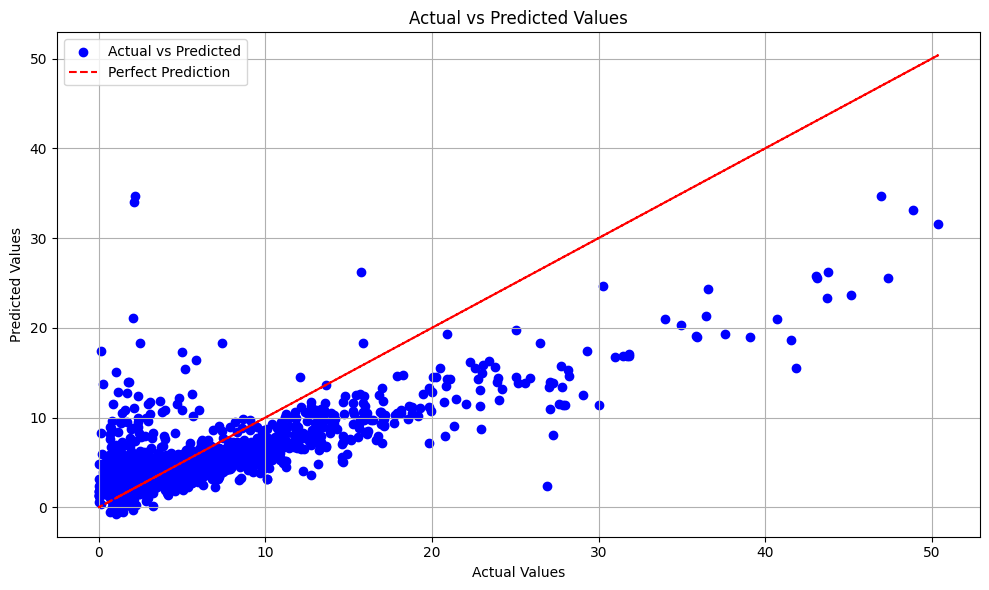

In [8]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Decision Tree Regressor

In [9]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
dt_model = tvs.fit(train_data)

predictions = dt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = dt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666| 3.878015750232992|
|(7,[0,1,6],[1312....| 1.1862|1.6786885274571532|
|(7,[0,1,6],[3840....| 3.5466|2.8909108531994976|
|[4732.0,72.0,0.0,...| 4.3483| 3.878015750232992|
|(7,[0,1,6],[1407....| 1.6412|1.6786885274571532|
|[2690.0,76.0,1.0,...| 1.2469| 1.837051871657752|
|[3108.0,60.0,1.0,...| 3.0237|2.8909108531994976|
|[12627.0,75.0,1.0...|  7.128| 7.622413611111112|
|(7,[0,1,6],[5825....| 2.7712| 3.878015750232992|
|[2386.0,55.0,1.0,...|  2.036|2.2996812449474517|
|[21649.0,78.0,1.0...|15.2614|13.335113008130083|
|[1806.0,54.0,0.0,...| 2.0859|1.6786885274571532|
|[2061.0,44.0,0.0,...| 2.0667|1.6786885274571532|
|(7,[0,1,6],[3671....| 2.7446|2.8909108531994976|
|[18940.0,71.0,1.0...|12.8558|13.335113008130083|
|(7,[0,1,6],[2581....| 2.0323|2.2996812449474517|
|[1942.0,56.0,1.0,...| 1.3305|1.2841468713105089|


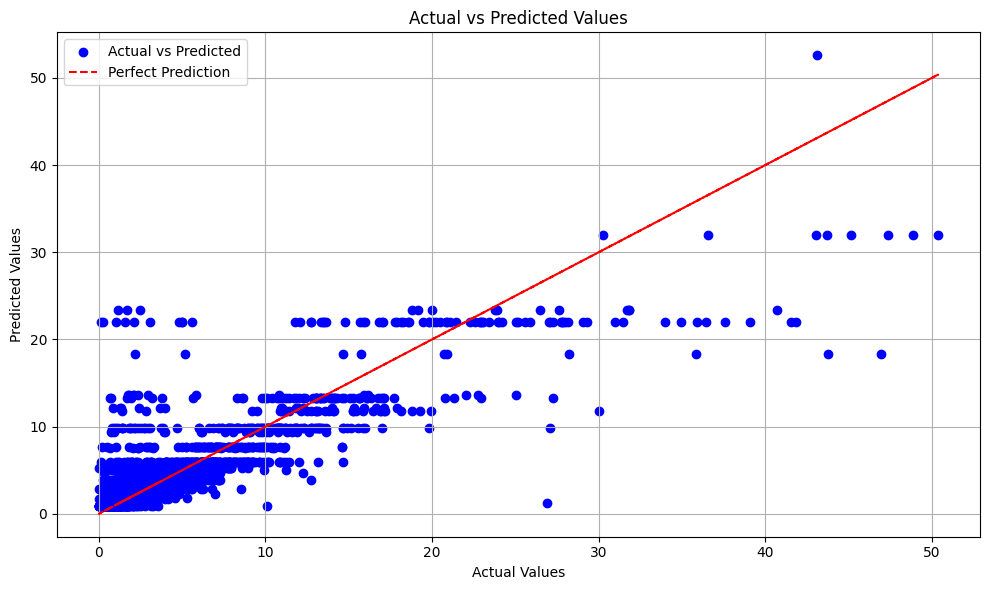

In [10]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gradient-Boosted Trees Regressor (GBT)

In [11]:
gbt = GBTRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
gbt_model = tvs.fit(train_data)

predictions = gbt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = gbt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666| 3.747915476990984|
|(7,[0,1,6],[1312....| 1.1862|1.5704523229615888|
|(7,[0,1,6],[3840....| 3.5466|  3.02369928524603|
|[4732.0,72.0,0.0,...| 4.3483|3.7423365999963365|
|(7,[0,1,6],[1407....| 1.6412| 1.660653220396437|
|[2690.0,76.0,1.0,...| 1.2469| 2.029553816271289|
|[3108.0,60.0,1.0,...| 3.0237|2.3922065420869685|
|[12627.0,75.0,1.0...|  7.128| 7.504384699264576|
|(7,[0,1,6],[5825....| 2.7712|4.1505323664963605|
|[2386.0,55.0,1.0,...|  2.036|2.2277083115689913|
|[21649.0,78.0,1.0...|15.2614| 13.39258596739774|
|[1806.0,54.0,0.0,...| 2.0859| 1.846592754621524|
|[2061.0,44.0,0.0,...| 2.0667|2.0332905571909246|
|(7,[0,1,6],[3671....| 2.7446|2.8441426448246703|
|[18940.0,71.0,1.0...|12.8558|14.590949580269553|
|(7,[0,1,6],[2581....| 2.0323| 2.277713553976849|
|[1942.0,56.0,1.0,...| 1.3305|1.3411511557031357|


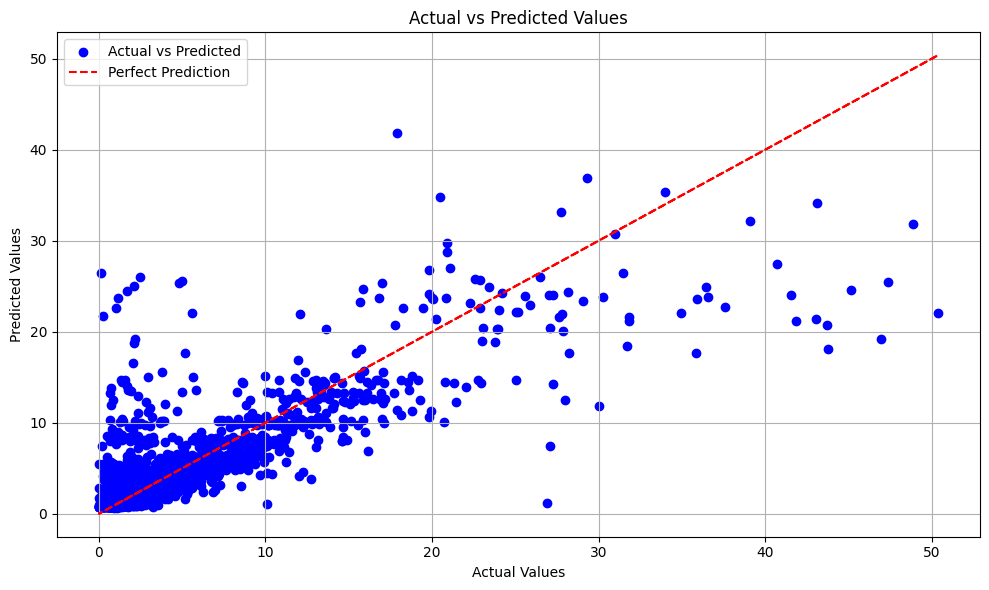

In [12]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()